In [303]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pytorchvideo.data.encoded_video import EncodedVideo
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import sys

%run objects
%run models

def read_video(id, view, type, needed_frames, backround_removal=False):
    """Reads video to numpy array using Open-CV"""
    if backround_removal:
        filepath = f"nfl-player-contact-detection/{type}/backround_removal/{id}_{view}.mp4"
    else:
        filepath = f"nfl-player-contact-detection/{type}/{id}_{view}.mp4"
    # Open the video file
    cap = cv2.VideoCapture(filepath)
    
    # Get video properties
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Initialize an empty numpy array to store the frames
    video_array = np.empty((len(needed_frames), height, width), dtype=np.uint8)
    
    # Loop through each frame and store it in the numpy array
    i=0
    for request_frame in needed_frames:
        if (request_frame >= num_frames) or (request_frame < 0):
            video_array[i]=np.zeros((height, width))
            continue
        cap.set(cv2.CAP_PROP_POS_FRAMES, request_frame)
        ret, frame = cap.read()
        if not ret:
            raise ValueError(f"Frame not returned for play {id} frame {request_frame}. There are {num_frames} frames.")
        if frame.shape[0]>1:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        video_array[i]=frame
        i+=1
    # Release the video object
    cap.release()
    return video_array

In [304]:
image=read_video(id = "58180_000986", view="Sideline", type="train", needed_frames=[1043])

print(image.shape)
plt.imshow(image[0], cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

ValueError: Frame not returned for play 58180_000986 frame 1043. There are 1043 frames.

In [290]:
train_dataset = ContactDataset(os.getcwd() + "/nfl-player-contact-detection/train_labels.csv",
                               ground=False, feature_size=256, num_back_forward_steps=1, 
                               skips=1, distance_cutoff=5, N=100)

Data Sample Contains 100 observations.


tensor([0.])


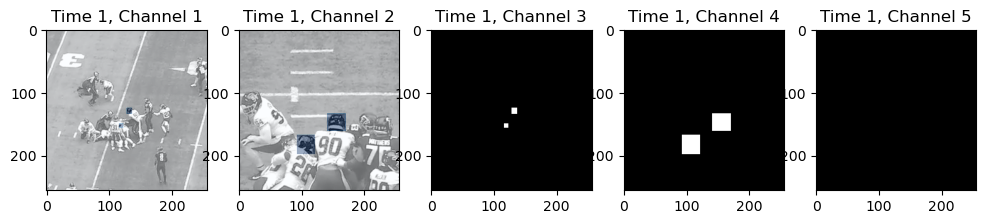

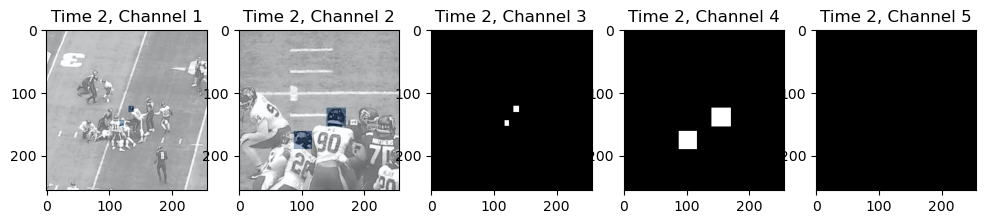

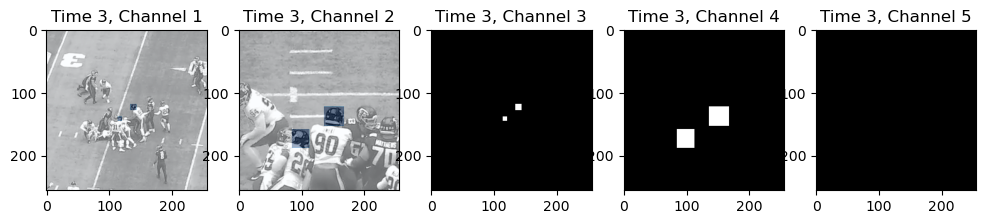

In [294]:
images=train_dataset[99]
j = 0
for image in images[0]:
    j+=1
    fig, axs = plt.subplots(1, 5, figsize=(12, 4)) 
    for i in range(5):
        channel = image[i, :, :]
        axs[i].imshow(channel, cmap='gray') 
        if i==0 or i==1:
            axs[i].imshow(image[i+2, :, :], alpha=0.4, cmap='Blues')  
        axs[i].set_title(f'Time {j}, Channel {i+1}')
print(images[1])

In [49]:
train_dataset[0][0][0].shape

torch.Size([5, 256, 256])

In [11]:
dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [12]:
image_size = 256
input_size = 100  # Output size of the Encoder's fully connected layer
hidden_size = 64
num_layers = 2
dropout = 0.1
learning_rate = 0.001
num_epochs = 10

In [13]:
combined_model = ContactNet(image_size, input_size, hidden_size, num_layers, dropout)
device = torch.device('cpu')
combined_model.to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(combined_model.parameters(), lr=learning_rate)

In [14]:
for epoch in range(num_epochs):
    # Training loop
    combined_model.train()
    for batch_idx, (features, labels) in enumerate(dataloader):
        x1, x2, x3 = features
        # Forward pass
        outputs = combined_model(x1, x2, x3)

        loss = criterion(outputs.squeeze(), labels.squeeze().float())  # Compute loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
        # Print loss
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Batch [1/8], Loss: 0.6935
Epoch [1/10], Batch [2/8], Loss: 0.6927
Epoch [1/10], Batch [3/8], Loss: 0.6914
Epoch [1/10], Batch [4/8], Loss: 0.6909
Epoch [1/10], Batch [5/8], Loss: 0.6894
Epoch [1/10], Batch [6/8], Loss: 0.6882
Epoch [1/10], Batch [7/8], Loss: 0.6885
Epoch [1/10], Batch [8/8], Loss: 0.6865
Epoch [2/10], Batch [1/8], Loss: 0.6843
Epoch [2/10], Batch [2/8], Loss: 0.6799
Epoch [2/10], Batch [3/8], Loss: 0.6743
Epoch [2/10], Batch [4/8], Loss: 0.6753
Epoch [2/10], Batch [5/8], Loss: 0.6702
Epoch [2/10], Batch [6/8], Loss: 0.6660
Epoch [2/10], Batch [7/8], Loss: 0.6640
Epoch [2/10], Batch [8/8], Loss: 0.6611
Epoch [3/10], Batch [1/8], Loss: 0.6393
Epoch [3/10], Batch [2/8], Loss: 0.6230
Epoch [3/10], Batch [3/8], Loss: 0.6398
Epoch [3/10], Batch [4/8], Loss: 0.6228
Epoch [3/10], Batch [5/8], Loss: 0.6231
Epoch [3/10], Batch [6/8], Loss: 0.6011
Epoch [3/10], Batch [7/8], Loss: 0.5844
Epoch [3/10], Batch [8/8], Loss: 0.5815
Epoch [4/10], Batch [1/8], Loss: 0.5431


In [34]:
test_dataset = ContactDataset(os.getcwd() + "/nfl-player-contact-detection/test_labels.csv",
                               ground=False, feature_size=256, num_back_forward_steps=1, 
                               skips=1, distance_cutoff=5, num_per_classification=1000)
test_dataset._cache_all_features

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
0,58168_003392_0_38590_43854,58168_003392,2020-09-11T03:01:48.100Z,0,38590,43854,0
11798,58168_003392_46_37084_46522,58168_003392,2020-09-11T03:01:52.700Z,46,37084,46522,0
11799,58168_003392_46_44869_47944,58168_003392,2020-09-11T03:01:52.700Z,46,44869,47944,0
11800,58168_003392_46_44869_47837,58168_003392,2020-09-11T03:01:52.700Z,46,44869,47837,0
11801,58168_003392_46_44869_46137,58168_003392,2020-09-11T03:01:52.700Z,46,44869,46137,0
...,...,...,...,...,...,...,...
4706095,58582_003121_30_46105_46121,58582_003121,2021-10-12T02:42:23.000Z,30,46105,46121,0
4706094,58582_003121_30_46105_52609,58582_003121,2021-10-12T02:42:23.000Z,30,46105,52609,0
4706093,58582_003121_30_45287_52619,58582_003121,2021-10-12T02:42:23.000Z,30,45287,52619,0
4706091,58582_003121_30_45287_47906,58582_003121,2021-10-12T02:42:23.000Z,30,45287,47906,0


(711, 720, 1280)

In [97]:
train_info = pd.read_csv("/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train_labels.csv")
train_info

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
0,58168_003392_0_38590_43854,58168_003392,2020-09-11T03:01:48.100Z,0,38590,43854,0
1,58168_003392_0_38590_41257,58168_003392,2020-09-11T03:01:48.100Z,0,38590,41257,0
2,58168_003392_0_38590_41944,58168_003392,2020-09-11T03:01:48.100Z,0,38590,41944,0
3,58168_003392_0_38590_42386,58168_003392,2020-09-11T03:01:48.100Z,0,38590,42386,0
4,58168_003392_0_38590_47944,58168_003392,2020-09-11T03:01:48.100Z,0,38590,47944,0
...,...,...,...,...,...,...,...
4721613,58582_003121_91_48220_G,58582_003121,2021-10-12T02:42:29.100Z,91,48220,G,0
4721614,58582_003121_91_47906_G,58582_003121,2021-10-12T02:42:29.100Z,91,47906,G,0
4721615,58582_003121_91_38557_G,58582_003121,2021-10-12T02:42:29.100Z,91,38557,G,0
4721616,58582_003121_91_47872_G,58582_003121,2021-10-12T02:42:29.100Z,91,47872,G,0


In [14]:
helmet = pd.read_csv("/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train_baseline_helmets.csv")
train_info = pd.read_csv("/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train_labels.csv")
tracking = pd.read_csv("/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train_player_tracking.csv")
train_info['frame'] = list(map(step_to_frame, train_info.step))

In [85]:
train_info.loc[train_info.contact==1]

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,frame
809,58168_003392_3_41944_42565,58168_003392,2020-09-11T03:01:48.400Z,3,41944,42565,1,317
1062,58168_003392_4_41944_42565,58168_003392,2020-09-11T03:01:48.500Z,4,41944,42565,1,323
1163,58168_003392_4_37084_38567,58168_003392,2020-09-11T03:01:48.500Z,4,37084,38567,1,323
1289,58168_003392_5_43854_46445,58168_003392,2020-09-11T03:01:48.600Z,5,43854,46445,1,329
1315,58168_003392_5_41944_42565,58168_003392,2020-09-11T03:01:48.600Z,5,41944,42565,1,329
...,...,...,...,...,...,...,...,...
4720589,58582_003121_87_39971_G,58582_003121,2021-10-12T02:42:28.700Z,87,39971,G,1,821
4720842,58582_003121_88_39971_G,58582_003121,2021-10-12T02:42:28.800Z,88,39971,G,1,827
4721095,58582_003121_89_39971_G,58582_003121,2021-10-12T02:42:28.900Z,89,39971,G,1,833
4721348,58582_003121_90_39971_G,58582_003121,2021-10-12T02:42:29.000Z,90,39971,G,1,839


In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pytorchvideo.data.encoded_video import EncodedVideo
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
from objects import step_to_frame, create_boxes_dict, ContactDataset
from models import Encoder, LSTMModel, ContactNet
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("CUDA is available! Using GPU.")
else:
    device = torch.device("cpu")  # Use CPU
    print("CUDA is not available. Using CPU.")

print("---Loading Train Dataloader----")
dataset = ContactDataset(os.getcwd() + "/nfl-player-contact-detection/train_labels.csv",
                      ground=False, feature_size=256, num_back_forward_steps=1, skips=1, distance_cutoff=5, num_per_classification=10)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

image_size = 128
input_size = 100  # Output size of the Encoder's fully connected layer
hidden_size = 64
num_layers = 2
dropout = 0.1
learning_rate = 0.001
num_epochs = 10

print("---Initializing Model----")
combined_model = ContactNet(image_size, input_size, hidden_size, num_layers, dropout)
combined_model.to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(combined_model.parameters(), lr=learning_rate)


print("---Training----")
for epoch in range(num_epochs):
    # Training loop
    combined_model.train()
    print(f"---Epoch {epoch}----")
    for batch_idx, (features, labels) in enumerate(dataloader):
        print(f"Batch {batch_idx}")
        x1, x2, x3, x4, x5 = features
        x1, x2, x3, x4, x5, labels = x1.to(device), x2.to(device), x3.to(device), x4.to(device), x5.to(device), labels.to(device)
        # Forward pass
        outputs = combined_model(x1, x2, x3, x4, x5)
        loss = criterion(outputs.squeeze(), labels.float())  # Compute loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print loss
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

/Users/nickbachelder/opt/anaconda3/envs/data-science/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is not available. Using CPU.
---Loading Train Dataloader----
Data Sample Contains 20 observations.
---Initializing Model----
---Training----
---Epoch 0----
Batch 0


ValueError: not enough values to unpack (expected 5, got 3)

In [87]:
def read_video(id, view, type, backround_removal=False):
    """Reads video to numpy array using Open-CV"""
    if backround_removal:
        filepath = f"nfl-player-contact-detection/{type}/backround_removal/{id}_{view}.mp4"
    else:
        filepath = f"nfl-player-contact-detection/{type}/{id}_{view}.mp4"
    # Open the video file
    cap = cv2.VideoCapture(filepath)
    
    # Get video properties
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    
    # Initialize an empty numpy array to store the frames
    video_array = np.empty((num_frames, 3, height, width), dtype=np.uint8)
    
    # Loop through each frame and store it in the numpy array
    for i in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break
        video_array[i] = frame.transpose(2, 0, 1)
        
    # Release the video object
    cap.release()
    return video_array

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

In [88]:
image=read_video(id = "58168_003392", view="Sideline", type="train", backround_removal=False)[0]
image.shape

(3, 720, 1280)

In [106]:

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.shape[1:],
    mode="bicubic",
    align_corners=False,
).squeeze()

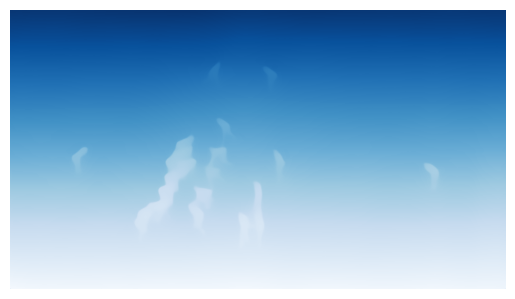

In [115]:
plt.imshow(prediction, cmap='Blues_r')
plt.axis('off')  # Turn off axis
plt.show()

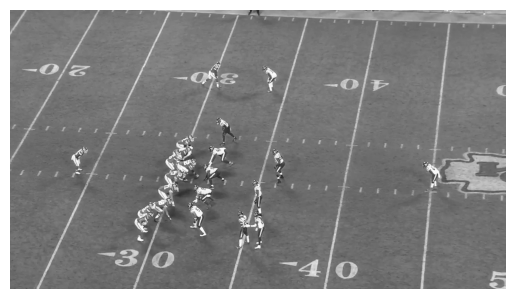

(711, 720, 1280)

In [113]:
pd.read_csv(os.getcwd() + "/nfl-player-contact-detection/sample_submission.csv")

,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0
...,...,...
49583,58172_003247_125_40656_G,0
49584,58172_003247_125_52521_G,0
49585,58172_003247_125_52939_G,0
49586,58172_003247_125_39008_G,0


In [120]:
train_labels = pd.read_csv(os.getcwd() + "/nfl-player-contact-detection/train_labels.csv")
train_labels[['game_play', 'step']].drop_duplicates().reset_index(drop=1)

,game_play,step
0,58168_003392,0
1,58168_003392,1
2,58168_003392,2
3,58168_003392,3
4,58168_003392,4
...,...,...
18663,58582_003121,87
18664,58582_003121,88
18665,58582_003121,89
18666,58582_003121,90


In [125]:
base = "/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train/58580_001136_Sideline.mp4".split("/")[-1]
game_play = base.split("_")[0]+ "_"+base.split("_")[1]
game_play

'58580_001136'

In [130]:
from itertools import chain



{-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}